In [6]:
import numpy as np
import os 
import argparse
import cmath
import random
from numpy.linalg import norm
from numpy.linalg import inv
from numpy import matmul, transpose
import matplotlib.pyplot as plt
j = complex(0,1)

Y_SIZE = 512
H_SIZE = 32
SIG1 = np.sqrt(0.001)
SIG2 = np.sqrt(0.1)
LAMBDA = 0.2
M = 100 # Number of trials

[[-0.00135161+0.00045644j]
 [-0.0009059 +0.00019696j]
 [-0.00204251+0.00063021j]
 [ 0.00043683+0.00066373j]
 [ 0.00181669+0.00177302j]]


In [122]:
# Constructing X and F

F = np.empty((Y_SIZE,H_SIZE),dtype=np.csingle) 
for i in range(F.shape[0]):
    for k in range(F.shape[1]):
        F[i][k] = cmath.exp(1j*(2*cmath.pi*i*k/512))        

# Noise vectors of different variances
# n1 = np.random.normal(loc=0, scale=SIG1,size=(Y_SIZE,2)).view(np.complex128)
# n2 = np.random.normal(loc=0, scale=SIG2,size=(Y_SIZE,2)).view(np.complex128)

# Constructing h
def get_x_h():
    x = np.random.choice([1+1j,1-1j,-1+1j,-1-1j],size=Y_SIZE)
    X = np.diag(x,k=0)
    p = np.asarray([np.exp(-1*(LAMBDA)*i) for i in range(H_SIZE)])
    p = p/np.sum(p**2)
    a = np.random.normal(scale=0.5,size=H_SIZE)
    b = np.random.normal(scale=0.5,size=H_SIZE)
    # Reshape added else y was taking size 512*512
    h = np.multiply(p,a+b*j).reshape(-1,1)
    return X,h

# Calculate A, where A = XF and y = XFh + n
X,h = get_x_h()
print(h)
A = matmul(X,F)

[[ 1.63207536e-01-2.67601531e-01j]
 [ 2.18030283e-01-6.26877263e-02j]
 [-5.34581044e-02+1.12375321e-01j]
 [-1.64353506e-01+4.11273208e-02j]
 [ 5.51003795e-02-4.51421493e-02j]
 [-6.00964458e-04+9.15755183e-02j]
 [ 1.66494585e-02+2.45322307e-02j]
 [ 7.07359956e-02-2.67666751e-02j]
 [ 3.65607788e-02-2.16035345e-02j]
 [ 7.79571734e-02-3.40752554e-02j]
 [ 3.33235655e-03-4.32261286e-03j]
 [-1.73436413e-03-2.30114907e-02j]
 [-1.07903202e-02+2.32153313e-02j]
 [ 6.59605922e-03+1.59378031e-02j]
 [ 8.11622585e-03+1.63663816e-02j]
 [-1.09318031e-02+4.16791047e-03j]
 [ 1.14088106e-02-9.87837207e-05j]
 [ 8.60778654e-03-1.44107333e-03j]
 [-5.02683724e-04-5.22787481e-03j]
 [-5.73408326e-03+3.65337390e-03j]
 [-3.99811609e-04-6.78580061e-04j]
 [ 4.24895899e-04-1.74931090e-03j]
 [-2.09638637e-03-3.29615184e-03j]
 [-3.42477198e-03-8.99929609e-04j]
 [-4.21581864e-04+5.68900756e-06j]
 [ 7.77101481e-04-1.50053674e-03j]
 [-1.84849358e-04+2.17703338e-05j]
 [ 8.52642310e-04-4.86500701e-04j]
 [-6.72739616e-04-5.

In [116]:
def pinv(A, alpha=0):
    Ah = np.asmatrix(A).getH()
    return  matmul(inv(matmul(Ah,A)+alpha*np.eye(np.shape(Ah)[0])),Ah)

def squared_error_theo(design_matrix, vector, alpha=0):
    projection_matrix = np.matmul(design_matrix, pinv(design_matrix, alpha))
    I = np.eye(np.shape(projection_matrix)[0])
    projection_matrix_perp = I - projection_matrix
    return norm(np.matmul(projection_matrix_perp, vector))**2

In [125]:
def normalized_difference(y_original, y_hat):
    return norm(y_original-y_hat)/norm(y_original)

def squared_error(vector1, vector2):
    return norm(vector1-vector2)**2


In [147]:
# Q1
def estimate_vanilla_h(A,h,sig=SIG1, rse=False):
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y = matmul(A,h) + n
    h_hat = matmul(pinv(A), y)
    d = normalized_difference(h,h_hat)
    y_hat = np.matmul(A, h_hat)
#     print(norm(y)**2)
#     print(f"[Vanilla] Normalized difference for variance {np.round(sig**2, decimals=3)} : {d}")
    error_theoretical = squared_error_theotical(A, y)
    error_calculated = squared_error(y, y_hat)
    if rse:
        return h_hat,d, error_theoretical, error_calculated
    else:
        return h_hat,d

# def estimate_vanilla_h(A,h,sig=SIG1):
#     n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
#     y = matmul(A,h) + n
#     h_hat = matmul(pinv(A), y)
#     d = normalized_difference(h,h_hat)
# #     print(f"[Vanilla] Normalized difference for variance {np.round(sig**2, decimals=3)} : {d}")
#     return h_hat,d
    
# estimate_vanilla_h(sig=SIG1)
# estimate_vanilla_h(sig=SIG2)

# Averaging over M trials
def question1(M=M,sig=SIG1):
    all_h = []
    all_h_hat = []
    error_theo = []
    error_calc = []
    for i in range(M):
        X,h = get_x_h()
        A = matmul(X,F)
        h_hat, d, error_theo_, error_calc_ = estimate_vanilla_h(A,h,sig,True)
        error_theo.append(error_theo_)
        error_calc.append(error_calc_)
        all_h.append(h)
        all_h_hat.append(h_hat)
    print(" MSE Theoretical :", np.mean(error_theo))
    print(" MSE Calculated :", np.mean(error_calc))
    return all_h, all_h_hat

all_hq1, all_h_hatq1 = question1(M,sig=SIG1)
mean_h = sum(all_hq1)/M
mean_h_hat = sum(all_h_hatq1)/M
error = [ np.sum(norm(all_hq1[i]-all_h_hatq1[i])**2) for i in range(M)  ]
print(np.mean(error))

 MSE Theoretical : 0.9598625124141096
 MSE Calculated : 0.9598625124141096
6.321311316367065e-05


0.017085938556473324


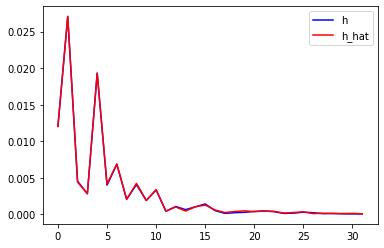

<Figure size 2880x1440 with 0 Axes>

In [141]:
print(normalized_difference(all_hq1[0],all_h_hatq1[0]))
def plot_h(h,h_hat):
    m = len(h)
#     print(normalized_difference(mean_h,mean_h_hat))
    norm_h = [norm(a) for a in h]
    norm_h_hat = [norm(a) for a in h_hat]
    plt.plot(np.arange(0,m),norm_h,'-b',label='h')
    plt.plot(np.arange(0,m),norm_h_hat,'-r',label='h_hat')
    plt.legend(loc='upper right')
    plt.figure(figsize=(40,20))
    plt.show()  

plot_h(mean_h,mean_h_hat)

0.11824186729258067


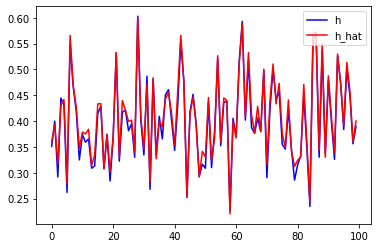

<Figure size 2880x1440 with 0 Axes>

In [16]:
all_h2,all_h_hat2 = question1(sig=SIG2)
print(normalized_difference(sum(all_h2),sum(all_h_hat2)))
plot_h(all_h2,all_h_hat2)

normalized difference : 0.04834467567995497


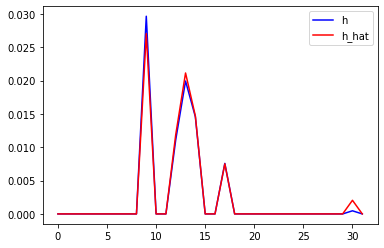

<Figure size 2880x1440 with 0 Axes>

In [146]:
# Q2
def estimate_sparse_h(A=A,h=h,sig=SIG1,sparsity_points=None,rse = False):
    # rse is return squared errors
    h_sparse = h
#     if sparsity_points is None:
#         sparsity_points = [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
#     for i in sparsity_points:
#         h_sparse[i] = 0
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y_sparse = np.matmul(A,h_sparse) + n
    constraints_matrix = np.zeros((len(sparsity_points), H_SIZE))
    for i in range(len(sparsity_points)):
        constraints_matrix[i,sparsity_points[i]]=1
    h_hat_unconstrained = matmul(pinv(A), y_sparse)
    Ah = np.asmatrix(A).getH()
    
    lambda_ = matmul(2*inv(matmul(matmul(constraints_matrix, inv(matmul(Ah, A))), \
                                  transpose(constraints_matrix))), matmul(constraints_matrix, h_hat_unconstrained))
    h_hat_constrained = h_hat_unconstrained - 0.5*matmul(matmul(inv(matmul(Ah,A)), \
                                                                transpose(constraints_matrix)), lambda_)
    d_constrained = normalized_difference(h_sparse,h_hat_constrained)

    y_hat = A@h_sparse
    error_theoretical = squared_error_theotical(A, y_sparse)
    error_calculated = squared_error(y_sparse, y_hat)
    
    if rse:
        return h_hat_constrained,d_constrained, error_theoretical, error_calculated
    else:
#     print(f"[Sparse] Normalized difference for variance {np.round(sig**2, decimals=3)} : {d_constrained}")
        return h_hat_constrained,d_constrained

# estimate_sparse_h(sig=SIG1)
# estimate_sparse_h(sig=SIG2)

def question2(M=M,sig=SIG1,sparsity_points=None):
    all_h = []
    all_h_hat = []
    for i in range(M):
        X,h = get_x_h()
        if not sparsity_points:
            sparsity_points = [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
        h[sparsity_points] = 0
#         print(h)
        A = matmul(X,F)
        h_hat,d = estimate_sparse_h(A,h,sig,sparsity_points)
        all_h.append(h)
        all_h_hat.append(h_hat)
    return all_h, all_h_hat

all_hq2,all_h_hatq2 = question2(M,SIG1)
print("normalized difference :", normalized_difference(sum(all_hq2)/M,sum(all_h_hatq2)/M))
plot_h(all_hq2[0],all_h_hatq2[0])

0.21016563830808574


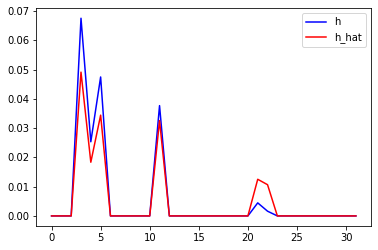

<Figure size 2880x1440 with 0 Axes>

In [97]:
all_h2q2,all_h_hat2q2 = question2(M,SIG2)
print(normalized_difference(sum(all_h2q2),sum(all_h_hat2q2)))
plot_h(all_h2q2[10],all_h_hat2q2[10])
# all_h_hat[0]
# norm(all_h_hat[0])


In [8]:
# Q3

# # Set guard bands of width 180 on either side
# X_ = X.copy()
# X_[:180] = 0
# X_[-180:] = 0
# A_ = matmul(X_,F)

# y1_ = matmul(A_,h) + n1
# y2_ = matmul(A_,h) + n2

# # define alpha values
# alpha1 = 1
# alpha2 = 1

# ## LSE
# h_hat1_ = matmul(pinv(A_, alpha1), y1_)
# h_hat2_ = matmul(pinv(A_, alpha2), y2_)
# d1_ = normalized_difference(h,h_hat1_)
# d2_ = normalized_difference(h,h_hat2_)

# # print("h vector was : ",h)
# # print("h_hat1 vector is :",h_hat1)
# # print("h_hat2 vector is :",h_hat2)
# print(f"Normalized difference for variance {np.round(SIG1**2, decimals=3)} and alpha {alpha1} : {d1}")
# print(f"Normalized difference for variance {np.round(SIG2**2, decimals=1)} and alpha {alpha2} : {d2}")

In [148]:
# Q3a


def estimate_guard_h_no_reg(A,h,h_,sig,sparsity_points,rse=False):
    # h_ is sparse h generated 
    h_vanilla,d_vanilla = estimate_vanilla_h(A=A,h=h,sig=sig,rse=rse)
    h_sparse,d_sparse = estimate_sparse_h(A=A,h=h_,sig=sig,sparsity_points=sparsity_points,rse=rse)
    return h_vanilla, h_sparse

# estimate_guard_h_no_reg(sig=SIG1)
# estimate_guard_h_no_reg(sig=SIG2)
sparse =  [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
h_ = h.copy()
h_[sparse] = 0
X_ = X.copy()
X_[:180] = 0
X_[-180:] = 0
A = matmul(X_,F)

h1,h2 = estimate_guard_h_no_reg(A,h,h_,SIG1,sparse)
# print(h2)
print(normalized_difference(h2,h_))
# Q3b
def estimate_guard_h_reg(A=A,h=h,alpha=1,sig=SIG1):
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y_ = matmul(A,h) + n
    h_hat_ = matmul(pinv(A, alpha), y_)
    d_ = normalized_difference(h,h_hat_)
#     print(f"[Regularized] Normalized difference for variance {np.round(sig**2, decimals=3)} and alpha {alpha} : {d_}")
    return h_hat_
    
# estimate_guard_h_reg(alpha=0.01,sig=SIG1)
h_hat = estimate_guard_h_reg(A,h,alpha=0.01,sig=SIG1)
print(normalized_difference(h,h_hat))
def question3_no_reg(M,sig=SIG1,sparsity_points=None):
    all_h = [[]]*4 # h, h_hat, h_sparse, h_hat_sparse
    for i in range(M):
        X,h = get_x_h()
        X[:180] = 0
        X[-180:] = 0
        A = matmul(X,F)
        h_ = h.copy()
        if not sparsity_points:
            sparsity_points = [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
        h_[sparsity_points] = 0
        h_vanilla,h_sparse = estimate_guard_h_no_reg(A,h,h_,sig,sparsity_points)
        all_h[1].append(h_vanilla)
        all_h[3].append(h_sparse)
        all_h[0].append(h)
        all_h[2].append(h_)
    return all_h
all_h = question3_no_reg(M=1,sig=SIG1)
all_hv, all_hv_hat, all_hs, all_hs_hat = all_h

# print(all_hv[0])
error = [np.sum(norm(all_hv[i]-all_hv_hat[i])**2) for i in range(len(all_hv))]

1.0000000001113707
0.6155279441880664


In [51]:
# print("With guard bands, the normalised difference for vanilla h is :", normalized_difference(sum(all_hv),sum(all_hv_hat)))

all_hv[1] == all_hv_hat[1]

matrix([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])

In [10]:
# Q4

# Building constraints matrix
number_of_constraints = 3
constraints_matrix = np.zeros((number_of_constraints, H_SIZE))
constraints_matrix[0,0]=1
constraints_matrix[0,1]=-1
constraints_matrix[1,2]=1
constraints_matrix[1,3]=-1
constraints_matrix[2,4]=1
constraints_matrix[2,5]=-1

def estimate_constrained_h(A=A,h=h,sig=SIG1):
    h_constrained = h.copy()
    h_constrained[0] = h_constrained[1]
    h_constrained[2] = h_constrained[3]
    h_constrained[4] = h_constrained[5]
    
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y_constrained = np.matmul(A,h_constrained) + n

    h_hat_unconstrained = matmul(pinv(A), y_constrained)
    Ah = np.asmatrix(A).getH()
    lambda_ = matmul(2*inv(matmul(matmul(constraints_matrix, inv(matmul(Ah, A))),\
                                  transpose(constraints_matrix))), matmul(constraints_matrix, h_hat_unconstrained))
    h_hat_constrained = h_hat_unconstrained - 0.5*matmul(matmul(inv(matmul(Ah,A)),\
                                                                transpose(constraints_matrix)), lambda_)
    d_constrained = normalized_difference(h_constrained,h_hat_constrained)
    print(f"[Constrained] Normalized difference for variance {np.round(sig**2, decimals=3)} : {d_constrained}")
    return h_hat_constrained,d_constrained

estimate_constrained_h(sig=SIG1)
estimate_constrained_h(sig=SIG2)

[Constrained] Normalized difference for variance 0.001 : 0.024363821477191707
[Constrained] Normalized difference for variance 0.1 : 0.26025496008323984


(matrix([[-0.13237759+0.09788829j],
         [-0.13237759+0.09788829j],
         [ 0.05957897-0.01742272j],
         [ 0.05957897-0.01742272j],
         [-0.02340432-0.0924025j ],
         [-0.02340432-0.0924025j ],
         [ 0.01382686-0.00672852j],
         [ 0.02350408+0.03152161j],
         [ 0.02820527-0.07113179j],
         [ 0.0273901 -0.00453935j],
         [-0.03046512-0.02221011j],
         [ 0.00874176-0.03184686j],
         [ 0.02145266-0.01938978j],
         [ 0.01554522+0.01383943j],
         [-0.00139744-0.00475811j],
         [-0.00168972-0.00288233j],
         [-0.00033072-0.00155752j],
         [ 0.00173731-0.02562347j],
         [-0.00633767+0.00737881j],
         [ 0.00685564+0.00344266j],
         [ 0.01919747-0.01331766j],
         [ 0.01111656+0.00894428j],
         [-0.01391023+0.01065036j],
         [-0.00963073-0.00312001j],
         [ 0.01278015-0.00724042j],
         [-0.00747396-0.02005627j],
         [ 0.00786309-0.01006674j],
         [ 0.00767993+0.0016

In [11]:
# Q5
Somp = []
n = np.random.normal(loc=0, scale=SIG2,size=(Y_SIZE,2)).view(np.complex128)
ran_sparse = 
y = matmul(A,h) + n
r = y.copy()
ko = 6
Ah = np.asmatrix(A).getH()
for k in range(ko):
    t_ = np.matmul(Ah,r)
    t = np.argmax(np.abs(np.matmul(Ah,r)))
    Somp.append(int(t))
    p = np.matmul(A[:,Somp],pinv(A[:,Somp]))
    r = np.matmul((np.eye(Y_SIZE) - p),y) 

sparsity_points = [x for x in range(H_SIZE) if x not in Somp]
estimate_sparse_h(sig=SIG2,sparsity_points=sparsity_points)

[Sparse] Normalized difference for variance 0.1 : 0.07941798286762564


(matrix([[-1.38848468e-01+2.13595317e-02j],
         [-1.47036660e-01+9.20469445e-02j],
         [ 1.61416246e-01+7.71074849e-02j],
         [ 0.00000000e+00+0.00000000e+00j],
         [ 6.92217113e-02+5.30732458e-02j],
         [-3.24060404e-02-9.65576823e-02j],
         [ 0.00000000e+00+0.00000000e+00j],
         [-2.16840434e-19+0.00000000e+00j],
         [ 4.65188115e-02-5.23655870e-02j],
         [ 0.00000000e+00+0.00000000e+00j],
         [ 0.00000000e+00+0.00000000e+00j],
         [ 0.00000000e+00+0.00000000e+00j],
         [-6.93889390e-18-1.73472348e-18j],
         [-3.46944695e-18+0.00000000e+00j],
         [ 0.00000000e+00+1.73472348e-18j],
         [ 0.00000000e+00+0.00000000e+00j],
         [ 8.67361738e-19+0.00000000e+00j],
         [ 0.00000000e+00-4.33680869e-19j],
         [ 0.00000000e+00+0.00000000e+00j],
         [ 1.73472348e-18-1.73472348e-18j],
         [ 0.00000000e+00+8.67361738e-19j],
         [ 0.00000000e+00+0.00000000e+00j],
         [ 0.00000000e+00-5.4210